In [1]:
# Real life data

import logging
import threading
import json
import itertools
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (ARIMAForecaster)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-03-09T19:29:23.378 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: ./
###_IBM_###


In [3]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./BP_DATA/IoTData.csv', index_col=False, parse_dates=['DATETIME'])

df_input_raw.rename(columns={'DATETIME':'timestamp'}, inplace=True)


df_input_raw['entity'] = 'demand'
#df_input_raw['entity']=df_input_raw['DEVICE_ID']
#df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

df_input_raw.describe()


2021-03-09T19:29:24.244 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-03-09T19:29:24.245 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


,UMIDADE_REL,KW,KW2
count,8336.000000,8336.000000,8336.000000
mean,67.781550,587.668072,58.766807
std,16.769073,154.291984,15.429198
min,15.000000,8.400000,0.840000
25%,57.000000,470.400000,47.040000
50%,73.000000,557.760010,55.776001
75%,81.000000,703.919983,70.391998
max,92.000000,944.160000,94.416000


In [4]:
# df_input[['accel_power_0','accel_anomaly']].head(20)

# removed 'rms'
#features=['accel_speed','accel_power_0','accel_power_1','accel_power_2','accel_power_3','accel_power_4'] 
features=['KW']
targets=['KW']
predictions=['KW_pred']

df_input = df_input_raw

In [9]:

# train with the first 6000 observations
df_cut = df_input[0:6000]

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)


arimaii = ARIMAForecaster(input_item='KW',n_forecast=120,
                     output_item='KW_pred')

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = arimaii._build_entity_type(columns = [Column('KW',Float())], **jobsettings)
arimaii._entity_type = et

# allow training and delete existing models
df_cut = arimaii.execute(df=df_cut)

2021-03-09T19:30:08.392 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-03-09T19:30:08.394 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 0.0.2
2021-03-09T19:30:08.394 DEBUG iotfunctions.util.__init__ Starting trace
2021-03-09T19:30:08.395 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_ARIMAForecaster_20210309183008
2021-03-09T19:30:08.395 DEBUG iotfunctions.util.__init__ auto_save None
2021-03-09T19:30:08.396 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-03-09T19:30:08.396 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-03-09T19:30:08.397 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_ARIMAFORECASTER
Functions:
Granularities:
No schedules metadata
2021-03-09T19:30:08.398 DEBUG mm

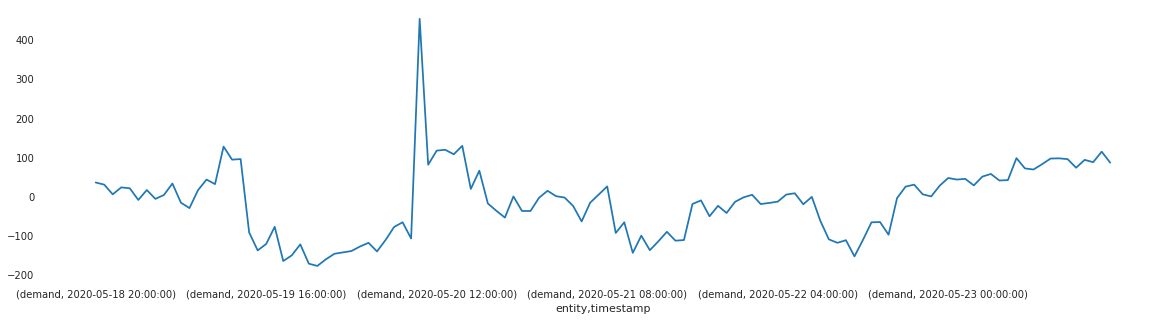

In [10]:
df_short = df_cut #[['KW', 'KW_pred']][5972:]
#df_short = df_cut[['KW']][5900:]
#df_short[['KW']][5900:6120].plot(figsize=(20,4))
#df_short[['KW_pred']][5800:].plot(figsize=(20,4))

diff = df_short['KW'][5880:6120] - df_short['KW_pred'][5760:]
diff.plot(figsize=(20,5))

In [ ]:
arimaii

#print('RMSE111: ', sm.tools.eval_measures.rmse(forecast111[0:24], ndif[6000:6000 + 24]),
#      '\nRMSE200: ', sm.tools.eval_measures.rmse(forecast200[0:24], ndif[6000:6000 + 24]))